In [1]:
#导入模块
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


### 数据预处理（合并、删除）

In [5]:
#合并附件8各年数据
dir_list = os.listdir("数据集/基本数据/附件8、锡林郭勒盟气候2012-2022/")
print(dir_list)
def merge_data(dir_list):
    df = pd.DataFrame()
    for i in range(len(dir_list)):
        d = pd.read_excel(os.path.join("数据集/基本数据/附件8、锡林郭勒盟气候2012-2022/",dir_list[i]))
        df = df.append(d)
    return df
        
df = merge_data(dir_list)   
 #删除字段
del df['积雪深度(mm)']
del df['平均最大瞬时风速(knots)']
del df['最大瞬时风速极值(knots)']       

In [26]:
#蒸发量
zf = pd.read_excel("数据集/基本数据/附件4、土壤蒸发量2012—2022年.xls")
"""print(zf.sort_index(ascending=False))
print(zf.sort_values(by='年份', inplace=True, ascending=False))"""

#径流量
jll = pd.read_excel("数据集/基本数据/附件9、径流量2012-2022年.xlsx")
#print(jll)

#湿度
sd_df =  pd.read_excel("数据集/基本数据/附件3、土壤湿度2022—2012年.xls")

# 合并自变量数据
m_df = pd.merge(zf,df)
m_df = pd.merge(m_df,jll)
#print(m_df.columns)

#有所有字段的数据
all_df = pd.merge(sd_df,m_df)
print(all_df.columns)

Index(['月份', '年份', '经度(lon)', '纬度(lat)', '土壤蒸发量(W/m2)', '土壤蒸发量(mm)', '站点号',
       '海拔高度(m)', '经度', '纬度', '平均气温(℃)', '平均最高气温(℃)', '平均最低气温(℃)', '最高气温极值(℃)',
       '最低气温极值(℃)', '平均气温≥18℃的天数', '平均气温≥35℃的天数', '平均气温≤0℃的天数', '平均露点温度(℃)',
       '降水量(mm)', '最大单日降水量(mm)', '降水天数', '平均海平面气压(hPa)', '最低海平面气压(hPa)',
       '平均站点气压(hPa)', '平均能见度(km)', '最小能见度(km)', '最大能见度(km)', '平均风速(knots)',
       '平均最大持续风速(knots)', '单日最大平均风速(knots)', '径流量(m3/s)', '径流量(m3)'],
      dtype='object')


In [30]:
# 预测变量、响应变量名称
x_names = list(all_df.columns[14:-2])
x_names.append("土壤蒸发量(mm)")
x_names.append("径流量(m3/s)")
y_names = list(all_df.columns[4:8])

# 提取自变量和各cm湿度数据
x = all_df[x_names]
y_10 =all_df["10cm湿度(kg/m2)"]
y_40=all_df["40cm湿度(kg/m2)"]
y_100=all_df["100cm湿度(kg/m2)"]
y_200=all_df["200cm湿度(kg/m2)"]



['平均气温(℃)', '平均最高气温(℃)', '平均最低气温(℃)', '最高气温极值(℃)', '最低气温极值(℃)', '平均气温≥18℃的天数', '平均气温≥35℃的天数', '平均气温≤0℃的天数', '平均露点温度(℃)', '降水量(mm)', '最大单日降水量(mm)', '降水天数', '平均海平面气压(hPa)', '最低海平面气压(hPa)', '平均站点气压(hPa)', '平均能见度(km)', '最小能见度(km)', '最大能见度(km)', '平均风速(knots)', '平均最大持续风速(knots)', '单日最大平均风速(knots)', '土壤蒸发量(mm)', '径流量(m3/s)']
['10cm湿度(kg/m2)', '40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)']
     平均气温(℃)  平均最高气温(℃)  平均最低气温(℃)  最高气温极值(℃)  最低气温极值(℃)  平均气温≥18℃的天数  \
0     -17.09      -8.99     -25.18      -2.00     -29.50            0   
1     -17.93     -10.55     -25.89      -0.89     -33.28            0   
2      -2.36       5.35     -11.22      15.22     -20.50            0   
3     -20.03     -13.46     -27.67      -2.11     -37.78            0   
4     -12.43      -5.52     -20.91       6.22     -30.22            0   
..       ...        ...        ...        ...        ...          ...   
118    19.87      26.51      12.21      32.50       1.39           24   
119    12.92      20.31  

### Lasso预测输出

In [2]:
#加载模块
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  #MSE
from sklearn.metrics import mean_absolute_error  #MAE
from sklearn import linear_model
import xgboost as xgb
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import MultiTaskLassoCV,MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler


In [51]:
### 线性回归
"""x_data = xgb.DMatrix(x)
y_data = xgb.DMatrix(y)"""

#划分训练测试集（设置随机种子）
x_train,x_test,y10_train,y10_test = train_test_split(x,y_10,test_size=0.3,random_state=111)

MSE of lm in test set: 1.4165292870268262
MSE of lm in train set: 1.0071147117782897


In [52]:
### lasso回归

#划分训练测试集（设置随机种子）
x_train,x_test,y10_train,y10_test = train_test_split(x,y_10,test_size=0.3,random_state=111)

#交叉验证寻找最优参数
Lambdas = np.logspace(-1, 1, 200)

# LASSO回归模型的交叉验证
lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(x_train, y10_train)
# 输出最佳的lambda值
lasso_best_alpha = lasso_cv.alpha_  # 0.1
print(lasso_best_alpha)


0.1


In [33]:
print(y10_train)

105    20.34
62     11.21
5      14.37
25     15.04
81     17.13
       ...  
86     14.73
120    15.04
122    14.42
108    13.56
84     15.55
Name: 10cm湿度(kg/m2), Length: 86, dtype: float64


In [53]:
## 10cm
lasso_lm = Lasso(alpha=lasso_best_alpha)
lasso_lm.fit(x_train,y10_train)

#性能评估： MSE
y10_pred = lasso_lm.predict(x_test)
y10_train_pred = lasso_lm.predict(x_train)
lasso_lm_MSE = mean_squared_error(y10_test,y10_pred)
lasso_lm_MSE_train = mean_squared_error(y10_train,y10_train_pred)
print('MSE of lm in test set:',lasso_lm_MSE)
print('MSE of lm in train set:',lasso_lm_MSE_train)


MSE of lm in test set: 1.2255395407768823
MSE of lm in train set: 1.0788659766676834


In [35]:
### 回归树
from sklearn import tree

#训练回归树
rtree = tree.DecisionTreeRegressor()
rtree = rtree.fit(x_train,y10_train_pred)

#性能度量
y10_pred = rtree.predict(x_test)
y10_train_pred = rtree.predict(x_train)
rtree_MSE = mean_squared_error(y10_test,y10_pred)
rtree_MSE_train = mean_squared_error(y10_train,y10_train_pred)
print('MSE of lm in test set:',rtree_MSE)
print('MSE of lm in train set:',rtree_MSE_train)

MSE of lm in test set: 4.638633847235705
MSE of lm in train set: 1.0788659766676834


In [63]:
#全数据拟合lasso
lasso_lm_all = Lasso(alpha=lasso_best_alpha)
lasso_lm_all.fit(x,y_100)

C:\Users\10371\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5187.541945236161, tolerance: 2.577903616260163
  positive)


Lasso(alpha=0.1)

In [64]:
coef = pd.DataFrame()
coef['x']=x_names
coef['coef']=lasso_lm_all.coef_
print(coef)

                  x       coef
0           平均气温(℃)  -1.894828
1         平均最高气温(℃)   5.112084
2         平均最低气温(℃)  -2.533862
3         最高气温极值(℃)  -0.379043
4         最低气温极值(℃)   0.392707
5       平均气温≥18℃的天数  -0.424312
6       平均气温≥35℃的天数   0.000000
7        平均气温≤0℃的天数   0.410034
8         平均露点温度(℃)   0.000000
9           降水量(mm)   0.017816
10      最大单日降水量(mm)   0.018531
11             降水天数  -0.000000
12     平均海平面气压(hPa)   1.462578
13     最低海平面气压(hPa)  -0.656376
14      平均站点气压(hPa)  -1.163623
15        平均能见度(km)   2.053887
16        最小能见度(km)  -0.765214
17        最大能见度(km)   0.509771
18      平均风速(knots)   5.426655
19  平均最大持续风速(knots)  -6.041706
20  单日最大平均风速(knots)  -0.038616
21        土壤蒸发量(mm)   0.524485
22        径流量(m3/s)  10.038554


### 加载新数据集

In [54]:
#降水
dir_list = os.listdir("数据集/基本数据/新数据集/")
print(dir_list)
#合并降水数据
def merge_data(dir_list):
    df = pd.DataFrame()
    for i in range(len(dir_list)-1):
        d = pd.read_excel(os.path.join("数据集/基本数据/新数据集/",dir_list[i]))
        df = df.append(d)
    return df
        
new_df = merge_data(dir_list)  

['2022年.xls', '2023.xls', '新土壤蒸发量202204—2023年.xls']


In [55]:
#删除字段
del new_df['积雪深度(mm)']
del new_df['平均最大瞬时风速(knots)']
del new_df['最大瞬时风速极值(knots)']

In [202]:
print(new_df)

            站点号  海拔高度(m)       经度      纬度    年份  月份    平均气温(℃)  平均最高气温(℃)  \
0   54102099999   1004.0  115.375  44.125  2022   4   7.610000  15.430000   
1   54102099999   1004.0  115.375  44.125  2022   5  12.950000  20.390000   
2   54102099999   1004.0  115.375  44.125  2022   6  19.590000  26.740000   
3   54102099999   1004.0  115.375  44.125  2022   7  23.310000  32.030000   
4   54102099999   1004.0  115.375  44.125  2022   8  20.127336  27.910854   
5   54102099999   1004.0  115.375  44.125  2022   9  14.076322  22.478874   
6   54102099999   1004.0  115.375  44.125  2022  10   4.458332  12.935853   
7   54102099999   1004.0  115.375  44.125  2022  11  -6.251655   1.394839   
8   54102099999   1004.0  115.375  44.125  2022  12 -15.284673  -8.109147   
0   54102099999   1004.0  115.375  44.125  2023   1 -17.450567  -9.508657   
1   54102099999   1004.0  115.375  44.125  2023   2 -13.753298  -5.590501   
2   54102099999   1004.0  115.375  44.125  2023   3  -1.965084   6.173177   

In [56]:
#蒸发
new_zf = pd.read_excel("数据集/基本数据/新数据集/新土壤蒸发量202204—2023年.xls")
"""print(new_zf.sort_index(ascending=False))
print(new_zf.sort_values(by='年份', inplace=True, ascending=False))"""
print(new_zf)

    月份    年份  经度(lon)  纬度(lat)  土壤蒸发量(W/m2)  土壤蒸发量(mm)
0    4  2022  115.375   44.125          NaN  10.687472
1    5  2022  115.375   44.125          NaN  19.079477
2    6  2022  115.375   44.125          NaN  25.919455
3    7  2022  115.375   44.125          NaN  27.396467
4    8  2022  115.375   44.125          NaN  16.537442
5    9  2022  115.375   44.125          NaN  12.447444
6   10  2022  115.375   44.125          NaN   9.478461
7   11  2022  115.375   44.125          NaN   3.943465
8   12  2022  115.375   44.125          NaN   2.209459
9    1  2023  115.375   44.125          NaN   1.969371
10   2  2023  115.375   44.125          NaN   2.078438
11   3  2023  115.375   44.125          NaN   5.455751
12   4  2023  115.375   44.125          NaN  10.822787
13   5  2023  115.375   44.125          NaN  19.214792
14   6  2023  115.375   44.125          NaN  26.054770
15   7  2023  115.375   44.125          NaN  27.531781
16   8  2023  115.375   44.125          NaN  16.672757
17   9  20

In [57]:
new_m_df = pd.merge(new_zf,new_df)
print(new_m_df.columns)

Index(['月份', '年份', '经度(lon)', '纬度(lat)', '土壤蒸发量(W/m2)', '土壤蒸发量(mm)', '站点号',
       '海拔高度(m)', '经度', '纬度', '平均气温(℃)', '平均最高气温(℃)', '平均最低气温(℃)', '最高气温极值(℃)',
       '最低气温极值(℃)', '平均气温≥18℃的天数', '平均气温≥35℃的天数', '平均气温≤0℃的天数', '平均露点温度(℃)',
       '降水量(mm)', '最大单日降水量(mm)', '降水天数', '平均海平面气压(hPa)', '最低海平面气压(hPa)',
       '平均站点气压(hPa)', '平均能见度(km)', '最小能见度(km)', '最大能见度(km)', '平均风速(knots)',
       '平均最大持续风速(knots)', '单日最大平均风速(knots)'],
      dtype='object')


In [58]:
#加载新数据
x_new =new_m_df[x_names]
print(x_new)

KeyError: "['径流量(m3/s)'] not in index"

In [43]:
def lasso_predict(x,y,r_seed):
    # LASSO回归模型的交叉验证寻找最优alpha
    Lambdas = np.logspace(-1, 1, 200)
    lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000,random_state=r_seed)
    lasso_cv.fit(x, y)
    # 输出最佳的lambda值
    lasso_best_alpha = lasso_cv.alpha_  # 0.1
    print("best alpha：",lasso_best_alpha)
    
    #全数据拟合lasso
    lasso_lm = Lasso(alpha=lasso_best_alpha)
    lasso_lm.fit(x,y)
    return lasso_lm

In [44]:
#新数据预测：10cm,40,100,200
y_new = pd.DataFrame()
lasso_10 = lasso_predict(x,y_10,111)
lasso_40 = lasso_predict(x,y_40,222)
lasso_100 = lasso_predict(x,y_100,333)
lasso_200 = lasso_predict(x,y_200,444)

y_new["新10cm湿度(kg/m2)"]= lasso_10.predict(x_new)
y_new["新40cm湿度(kg/m2)"]= lasso_40.predict(x_new)
y_new["新100cm湿度(kg/m2)"]= lasso_100.predict(x_new)
y_new["新200cm湿度(kg/m2)"]= lasso_200.predict(x_new)

print(y_new)

best alpha： 0.1
best alpha： 0.1


C:\Users\10371\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.40872788957768, tolerance: 0.6820169026016261
  positive)


best alpha： 10.0
best alpha： 10.0
    新10cm湿度(kg/m2)  新40cm湿度(kg/m2)  新100cm湿度(kg/m2)  新200cm湿度(kg/m2)
0        12.949788       45.295888        53.673974       167.354807
1        15.336701       46.960846        53.943474       167.337398
2        18.173935       49.087277        54.204537       167.312419
3        18.208249       51.261214        54.323596       167.309292
4        17.241540       47.907732        57.207758       167.095545
5        16.714819       48.797145        56.687194       167.136081
6        15.792566       48.399053        56.125237       167.171824
7        13.476770       48.465549        60.136196       166.869144
8        13.238444       47.385629        58.159150       167.013966
9        12.719687       47.598382        61.333784       166.773926
10       12.898357       49.871572        62.370207       166.700898
11       12.754218       44.813494        56.201397       167.159434
12       13.396399       44.099355        55.094970       167.243944


In [61]:
y_new.to_csv("新预测值.csv")

### Lasso计算湿度

### 降维后拟合?

In [208]:
x_10names = ['土壤蒸发量(mm)','平均露点温度(℃)','降水天数','最小能见度(km)','平均风速(knots)','径流量(m3/s)']
x_10 = all_df[x_10names]
y_10 = all_df['10cm湿度(kg/m2)']
#x_10new = new_m_df[x_10names]
"""lasso_10test  = lasso_predict(x_10test,y_10test,555)
print(lasso_10test.predict(x_10new))"""


'lasso_10test  = lasso_predict(x_10test,y_10test,555)\nprint(lasso_10test.predict(x_10new))'

In [204]:
print(all_df)

     月份    年份  经度(lon)  纬度(lat)  10cm湿度(kg/m2)  40cm湿度(kg/m2)  100cm湿度(kg/m2)  \
0     1  2022  115.375   44.125          12.45          52.14           93.45   
1     2  2022  115.375   44.125          12.10          52.14           93.45   
2     3  2022  115.375   44.125          14.96          52.13           93.44   
3     1  2021  115.375   44.125          15.17          50.40           82.44   
4     2  2021  115.375   44.125          13.93          50.40           82.44   
..   ..   ...      ...      ...            ...            ...             ...   
118   8  2012  115.375   44.125          15.76          44.94           61.25   
119   9  2012  115.375   44.125          17.12          45.67           55.29   
120  10  2012  115.375   44.125          15.04          42.49           54.69   
121  11  2012  115.375   44.125          14.79          42.71           55.02   
122  12  2012  115.375   44.125          14.42          42.71           55.02   

     200cm湿度(kg/m2)  土壤蒸发量(

In [210]:
### 线性回归
"""x_data = xgb.DMatrix(x)
y_data = xgb.DMatrix(y)"""


#划分训练测试集（设置随机种子）
x_train,x_test,y10_train,y10_test = train_test_split(x_10,y_10,test_size=0.3,random_state=111)


#训练模型
lm = linear_model.LinearRegression()
lm.fit(x_train,y10_train)

#性能评估： MSE
y10_pred = lm.predict(x_test)
y10_train_pred = lm.predict(x_train)
lm_MSE = mean_squared_error(y10_test,y10_pred)
lm_MSE_train = mean_squared_error(y10_train,y10_train_pred)
print('MSE of lm in test set:',lm_MSE)
print('MSE of lm in train set:',lm_MSE_train)


MSE of lm in test set: 2.1618902540700597
MSE of lm in train set: 1.877530994036278


In [222]:
#特征标准化处理提升预测准确性
scaler = StandardScaler()
scaler.fit(x_train) #只需在训练集上fit
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

#训练模型
lm = linear_model.LinearRegression()
lm.fit(x_train_std,y10_train)

#性能评估： MSE
y10_pred = lm.predict(x_test_std)
y10_train_pred = lm.predict(x_train_std)
lm_MSE = mean_squared_error(y10_test,y10_pred)
lm_MSE_train = mean_squared_error(y10_train,y10_train_pred)
print('MSE of lm in test set:',lm_MSE)
print('MSE of lm in train set:',lm_MSE_train)



MSE of lm in test set: 2.1618902540700584
MSE of lm in train set: 1.8775309940362777


In [221]:
print(x_train_std)

[[ 2.88687026e+00  1.51383166e+00  1.89836369e+00  1.77820700e+00
  -6.76528444e-02  2.72338690e-01]
 [-9.11222154e-01 -1.15951924e+00  9.12498488e-01 -8.24145269e-01
  -1.07996738e+00 -1.31011038e+00]
 [-2.43869815e-01 -2.72441789e-01 -7.33667126e-02 -1.09491025e+00
   6.93875327e-03  3.27810797e+00]
 [-7.34773013e-01 -5.98834586e-01 -1.05923191e+00 -1.85267612e+00
  -1.07996738e+00 -4.47977708e-01]
 [ 8.69041250e-01  1.52191069e+00  1.30684457e+00  8.40455886e-02
   6.93875327e-03  2.43607071e-01]
 [ 4.42211763e-01 -6.97398748e-01 -1.25640495e+00 -8.84315264e-01
  -3.55363292e-01  5.86176349e-01]
 [ 5.99931666e-01  2.93898189e-01  1.23806327e-01  1.14130586e-01
   2.26599857e+00 -3.15554435e-01]
 [-9.37837388e-01 -1.06903411e+00  3.20979368e-01 -1.15696055e+00
  -1.27177435e+00 -9.34389233e-01]
 [-9.21079648e-01 -1.67657714e+00 -1.25640495e+00 -1.24721554e+00
  -1.05865550e+00 -7.18902102e-01]
 [-8.80663923e-01 -9.19572063e-01  1.23806327e-01 -2.18684697e-01
  -6.43073741e-01 -8.7455

In [211]:
Lambdas = np.logspace(-1, 1, 200)

# LASSO回归模型的交叉验证
lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(x_train, y10_train)
# 输出最佳的lambda值
lasso_best_alpha = lasso_cv.alpha_  # 0.1
print(lasso_best_alpha)


0.1


In [212]:
lasso_lm = Lasso(alpha=lasso_best_alpha)
lasso_lm.fit(x_train,y10_train)

#性能评估： MSE
y10_pred = lasso_lm.predict(x_test)
y10_train_pred = lasso_lm.predict(x_train)
lasso_lm_MSE = mean_squared_error(y10_test,y10_pred)
lasso_lm_MSE_train = mean_squared_error(y10_train,y10_train_pred)
print('MSE of lm in test set:',lasso_lm_MSE)
print('MSE of lm in train set:',lasso_lm_MSE_train)

MSE of lm in test set: 2.350924828515322
MSE of lm in train set: 1.942705184828777


In [226]:
print(all_df)

     月份    年份  经度(lon)  纬度(lat)  10cm湿度(kg/m2)  40cm湿度(kg/m2)  100cm湿度(kg/m2)  \
0     1  2022  115.375   44.125          12.45          52.14           93.45   
1     2  2022  115.375   44.125          12.10          52.14           93.45   
2     3  2022  115.375   44.125          14.96          52.13           93.44   
3     1  2021  115.375   44.125          15.17          50.40           82.44   
4     2  2021  115.375   44.125          13.93          50.40           82.44   
..   ..   ...      ...      ...            ...            ...             ...   
118   8  2012  115.375   44.125          15.76          44.94           61.25   
119   9  2012  115.375   44.125          17.12          45.67           55.29   
120  10  2012  115.375   44.125          15.04          42.49           54.69   
121  11  2012  115.375   44.125          14.79          42.71           55.02   
122  12  2012  115.375   44.125          14.42          42.71           55.02   

     200cm湿度(kg/m2)  土壤蒸发量(

### 相关热力图

In [37]:
all_data = pd.concat([all_df[x_names],all_df[y_names]],axis=1)
print(all_data)
del all_data['平均气温≥35℃的天数']

     平均气温(℃)  平均最高气温(℃)  平均最低气温(℃)  最高气温极值(℃)  最低气温极值(℃)  平均气温≥18℃的天数  \
0     -17.09      -8.99     -25.18      -2.00     -29.50            0   
1     -17.93     -10.55     -25.89      -0.89     -33.28            0   
2      -2.36       5.35     -11.22      15.22     -20.50            0   
3     -20.03     -13.46     -27.67      -2.11     -37.78            0   
4     -12.43      -5.52     -20.91       6.22     -30.22            0   
..       ...        ...        ...        ...        ...          ...   
118    19.87      26.51      12.21      32.50       1.39           24   
119    12.92      20.31       4.85      28.28      -1.39            4   
120     4.32      11.16      -3.00      20.61     -11.22            0   
121    -9.43      -4.22     -15.79      14.00     -28.28            0   
122   -20.42     -14.81     -26.77      -4.61     -33.61            0   

     平均气温≥35℃的天数  平均气温≤0℃的天数  平均露点温度(℃)  降水量(mm)  ...  最大能见度(km)  平均风速(knots)  \
0              0          31     -21.92   

In [38]:
from scipy.stats import pearsonr,spearmanr
print(spearmanr(all_data)[0])

[[ 1.00000000e+00  9.96138623e-01  9.95949981e-01  9.63575946e-01
   9.78167636e-01  9.05613831e-01 -9.52551940e-01  9.72477005e-01
   2.45845023e-01  2.31953240e-01  2.68943128e-01 -9.63225822e-01
  -8.64991762e-01 -7.74873719e-01  3.44687040e-01  4.00790484e-01
   6.96988907e-02  3.66567294e-01  4.40105250e-01  3.33298595e-01
   8.96423965e-01  4.37276380e-01  6.41287699e-01  1.11049480e-01
  -4.39615380e-02  1.57663265e-02]
 [ 9.96138623e-01  1.00000000e+00  9.90735889e-01  9.59241948e-01
   9.77137330e-01  9.00671818e-01 -9.52608700e-01  9.71406414e-01
   2.40652092e-01  2.32434163e-01  2.64907664e-01 -9.59851284e-01
  -8.56225201e-01 -7.70647586e-01  3.54380664e-01  4.04198474e-01
   7.18963289e-02  3.48975683e-01  4.21521128e-01  3.13331476e-01
   8.97425025e-01  4.32123809e-01  6.46788244e-01  1.30726427e-01
  -1.27053597e-02 -7.13996735e-03]
 [ 9.95949981e-01  9.90735889e-01  1.00000000e+00  9.51636517e-01
   9.79317150e-01  9.04091616e-01 -9.48188947e-01  9.79998162e-01
   2.6

<AxesSubplot:>

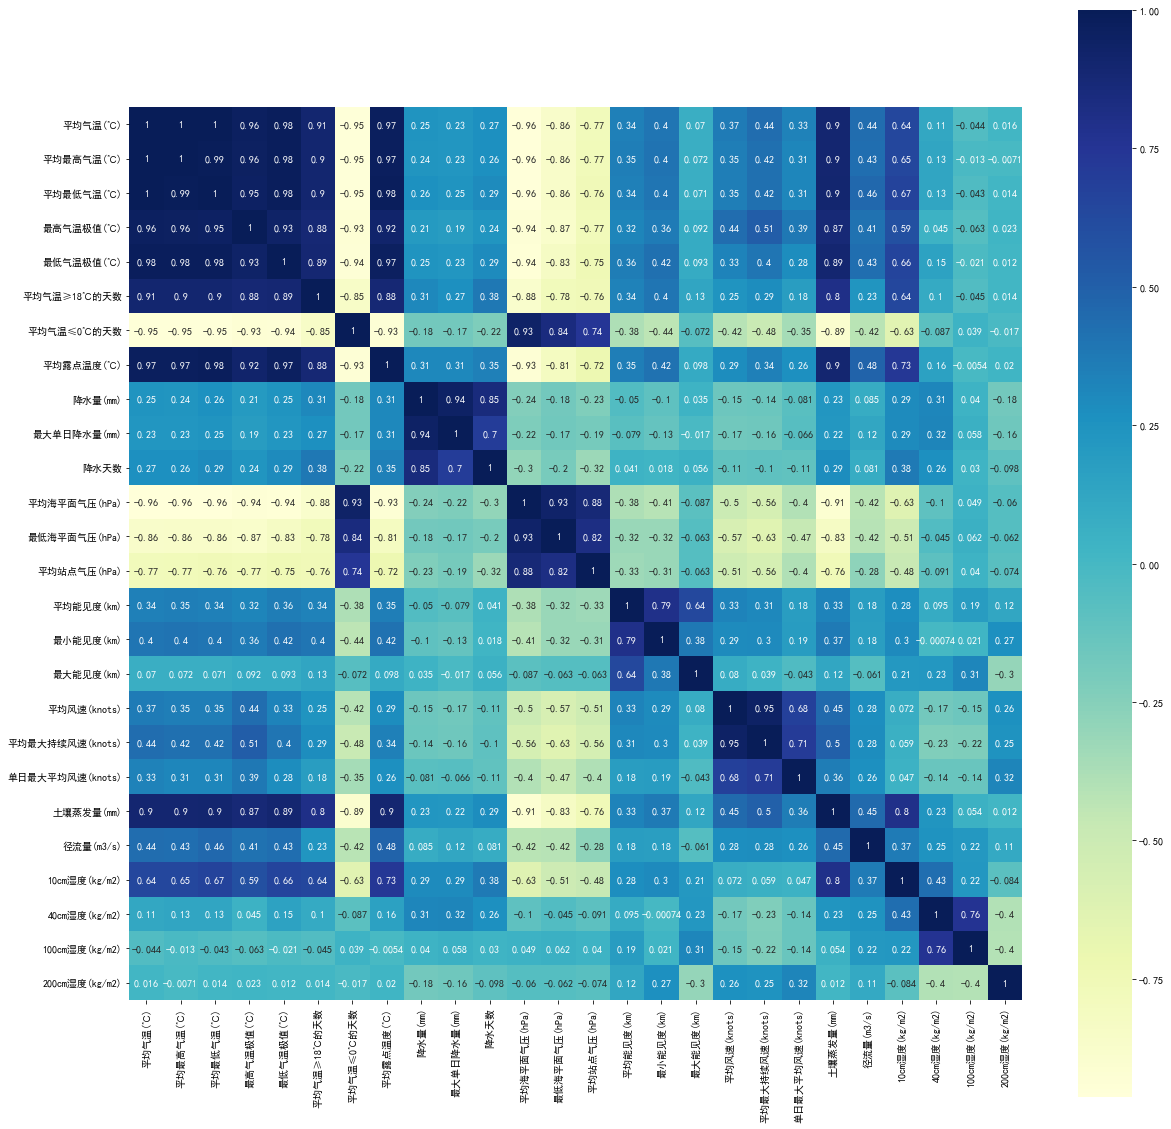

In [39]:
figure, ax = plt.subplots(figsize=(20, 20))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
sns.heatmap(spearmanr(all_data)[0], square=True, annot=True, ax=ax,cmap="YlGnBu",
            xticklabels=all_data.columns,yticklabels=all_data.columns)


### Q4

In [139]:
#层次分析
#人文因素层加入放牧强度因子

mat = np.array([[1,1/2,1/2,1/2],[2,1,2,1],[2,1/2,1,1/2],[2,1,2,1]])
#mat = np.transpose(mat)
#mat = np.array([[1,2,2,3],[1/2,1,2,2],[1/2,1/2,1,1/2],[1/3,1/2,2,1]])

print(mat)

eigenvalue, featurevector = np.linalg.eig(mat)

#最大特征向量
k=[i for i in range(len(eigenvalue)) if eigenvalue[i] == np.max(eigenvalue)]
featurevector =featurevector[:,k].real
max_v = np.max(eigenvalue.real)

print("最大特征值：",max_v)
print("最大特征向量\n", featurevector)


min_f= min(featurevector)
max_f=max(featurevector)
mini = max_f-min_f
std_vec = (featurevector)/sum(featurevector)

print("特征向量标准化\n",std_vec)

ci = (max_v-4)/3
cr = ci/0.9
print("ci=",ci)
print("cr=",cr)

[[1.  0.5 0.5 0.5]
 [2.  1.  2.  1. ]
 [2.  0.5 1.  0.5]
 [2.  1.  2.  1. ]]
最大特征值： 4.060647027554148
最大特征向量
 [[0.26664185]
 [0.62661131]
 [0.37897052]
 [0.62661131]]
特征向量标准化
 [[0.14042392]
 [0.32999777]
 [0.19958055]
 [0.32999777]]
ci= 0.02021567585138258
cr= 0.022461862057091758


In [143]:
#层次分析
#A层

mat = np.array([[1,1/2,1/2],[2,1,2],[2,1/2,1]])
#mat = np.transpose(mat)
print(mat)

eigenvalue, featurevector = np.linalg.eig(mat)

#最大特征向量
k=[i for i in range(len(eigenvalue)) if eigenvalue[i] == np.max(eigenvalue)]
featurevector =featurevector[:,k].real
max_v = np.max(eigenvalue.real)

print("最大特征值：",max_v)
print("最大特征向量\n", featurevector)

#标准化
min_f= min(featurevector)
max_f=max(featurevector)
mini = max_f-min_f
std_vec = (featurevector)/sum(featurevector)

print("特征向量标准化\n",std_vec)

ci = (max_v-3)/2
cr = ci/0.58
print("ci=",ci)
print("cr=",cr)

[[1.  0.5 0.5]
 [2.  1.  2. ]
 [2.  0.5 1. ]]
最大特征值： 3.053621575878972
最大特征向量
 [[0.31831244]
 [0.80209708]
 [0.5052895 ]]
特征向量标准化
 [[0.19580035]
 [0.49338597]
 [0.31081368]]
ci= 0.026810787939486103
cr= 0.04622549644738984


In [145]:
# a层权重
a_weight = std_vec

In [3]:
### 计算沙漠化程度指数
Q_NG = [0.32,0.9905,1,0.1,0.58,1,0,1,1,0]
Q_LGI =  [0.32,0.9905,1,0.1,0.58,1,0,1,1,1/3]
Q_MGI =  [0.32,0.9905,1,0.1,0.58,1,0,1,1,2/3]
Q_HGI =  [0.32,0.9905,1,0.1,0.58,1,0,1,1,1]
W = [0.1802,0.0787,0.0685,0.2036,0.0808,0.1282,0.0365,0.0858,0.0519,0.0858]
SM_NG =  np.multiply(np.array(Q_NG),np.array(W))
SM_LGI =  np.multiply(np.array(Q_LGI),np.array(W))
SM_MGI =  np.multiply(np.array(Q_MGI),np.array(W))
SM_HGI =  np.multiply(np.array(Q_HGI),np.array(W))

print(sum(SM_NG))
print(sum(SM_LGI))
print(sum(SM_MGI))
print(sum(SM_HGI))



0.53724035
0.56584035
0.5944403500000001
0.62304035


In [6]:
### 300、600、900、1200mm沙漠化程度指数sm计算(不同放牧强度下)
def sm_cal(js):
    js_q = (1200-js)/900
    Q_NG = [0.32,js_q,1,0.1,0.58,1,0,1,1,0]
    Q_LGI =  [0.32,js_q,1,0.1,0.58,1,0,1,1,1/3]
    Q_MGI =  [0.32,js_q,1,0.1,0.58,1,0,1,1,2/3]
    Q_HGI =  [0.32,js_q,1,0.1,0.58,1,0,1,1,1]
    W = [0.1802,0.0787,0.0685,0.2036,0.0808,0.1282,0.0365,0.0858,0.0519,0.0858]
    SM_NG =  np.multiply(np.array(Q_NG),np.array(W))
    SM_LGI =  np.multiply(np.array(Q_LGI),np.array(W))
    SM_MGI =  np.multiply(np.array(Q_MGI),np.array(W))
    SM_HGI =  np.multiply(np.array(Q_HGI),np.array(W))
    print(js,"mm时不同放牧强度下的沙漠化指数为：\n")
    print(sum(SM_NG))
    print(sum(SM_LGI))
    print(sum(SM_MGI))
    print(sum(SM_HGI))

In [7]:
sm_cal(300)
sm_cal(600)
sm_cal(900)
sm_cal(1200)

300 mm时不同放牧强度下的沙漠化指数为：

0.5379880000000001
0.5665880000000001
0.5951880000000002
0.6237880000000001
600 mm时不同放牧强度下的沙漠化指数为：

0.5117546666666666
0.5403546666666665
0.5689546666666666
0.5975546666666666
900 mm时不同放牧强度下的沙漠化指数为：

0.4855213333333333
0.5141213333333333
0.5427213333333333
0.5713213333333333
1200 mm时不同放牧强度下的沙漠化指数为：

0.459288
0.487888
0.516488
0.545088


In [137]:
##板结化W、C、O的ahp层次分析

mat = np.array([[1,2,3],[1/2,1,2],[1/3,1/2,1]])
#mat = np.transpose(mat)
print(mat)

eigenvalue, featurevector = np.linalg.eig(mat)

#最大特征向量
k=[i for i in range(len(eigenvalue)) if eigenvalue[i] == np.max(eigenvalue)]
featurevector =featurevector[:,k].real
max_v = np.max(eigenvalue.real)

print("最大特征值：",max_v)
print("最大特征向量\n", featurevector)


min_f= min(featurevector)
max_f=max(featurevector)
mini = max_f-min_f
std_vec = (featurevector)/sum(featurevector)

print("特征向量标准化\n",std_vec)

ci = (max_v-3)/2
cr = ci/0.58
print("ci=",ci)
print("cr=",cr)

[[1.         2.         3.        ]
 [0.5        1.         2.        ]
 [0.33333333 0.5        1.        ]]
最大特征值： 3.0092027127142806
最大特征向量
 [[0.84679693]
 [0.46601031]
 [0.25645536]]
特征向量标准化
 [[0.53961455]
 [0.29696133]
 [0.16342412]]
ci= 0.004601356357140318
cr= 0.007933373029552273


### 附件15数据

In [163]:

data_15 = pd.read_excel("数据集/监测点数据/附件15：内蒙古自治区锡林郭勒盟典型草原轮牧放牧样地群落结构监测数据集（2016年6月-2020年9月）/内蒙古自治区锡林郭勒盟典型草原轮牧放牧样地群落结构监测数据集.xlsx")
print(data_15)



        年份     轮次      处理         日期  植物种名 植物群落功能群 放牧小区Block  重复   营养苗   生殖苗  \
0     2019     牧前  轻牧（3天）  2019.5.10   大针茅      PB        G6   1  24.0   NaN   
1     2019     牧前  轻牧（3天）  2019.5.10    羊草      PR        G6   1  12.0   NaN   
2     2019     牧前  轻牧（3天）  2019.5.10    苔草      PR        G6   1  11.0   NaN   
3     2019     牧前  轻牧（3天）  2019.5.10  糙隐子草      PB        G6   1   4.0   NaN   
4     2019     牧前  轻牧（3天）  2019.5.10    知母      PF        G6   1   4.0   NaN   
...    ...    ...     ...        ...   ...     ...       ...  ..   ...   ...   
8791  2016  第四轮牧后  无牧（0天）  2016.9.21  米氏冰草      PR       G21   4  30.0   NaN   
8792  2016  第四轮牧后  无牧（0天）  2016.9.21    羊草      PR       G21   5  57.0   NaN   
8793  2016  第四轮牧后  无牧（0天）  2016.9.21   大针茅      PB       G21   5  50.0  70.0   
8794  2016  第四轮牧后  无牧（0天）  2016.9.21    知母      PF       G21   5  34.0   NaN   
8795  2016  第四轮牧后  无牧（0天）  2016.9.21  米氏冰草      PR       G21   5  44.0   NaN   

       株/丛数   丛幅1   丛幅2   鲜重(g)  干重(g) 

### Q6绘图

In [10]:
#年蒸发数据
zf_data = pd.read_excel("数据集/基本数据/附件4、土壤蒸发量2012—2022年.xls")
"""print(zf.sort_index(ascending=False))
print(zf.sort_values(by='年份', inplace=True, ascending=False))"""

#年径流量
jll_data = pd.read_excel("数据集/基本数据/附件9、径流量2012-2022年.xlsx")
#print(jll)

#年湿度
sd_data =  pd.read_excel("数据集/基本数据/附件3、土壤湿度2022—2012年.xls")

#年NDVI
NDVI_data =  pd.read_excel("数据集/基本数据/附件6、植被指数-NDVI2012-2022年.xls")

#年LAI
LAI_data =  pd.read_excel("数据集/基本数据/附件10、叶面积指数（LAI）2012-2022年.xls")


# 合并自变量数据
m_df = pd.merge(zf,df)
m_df = pd.merge(m_df,jll)


NameError: name 'zf' is not defined

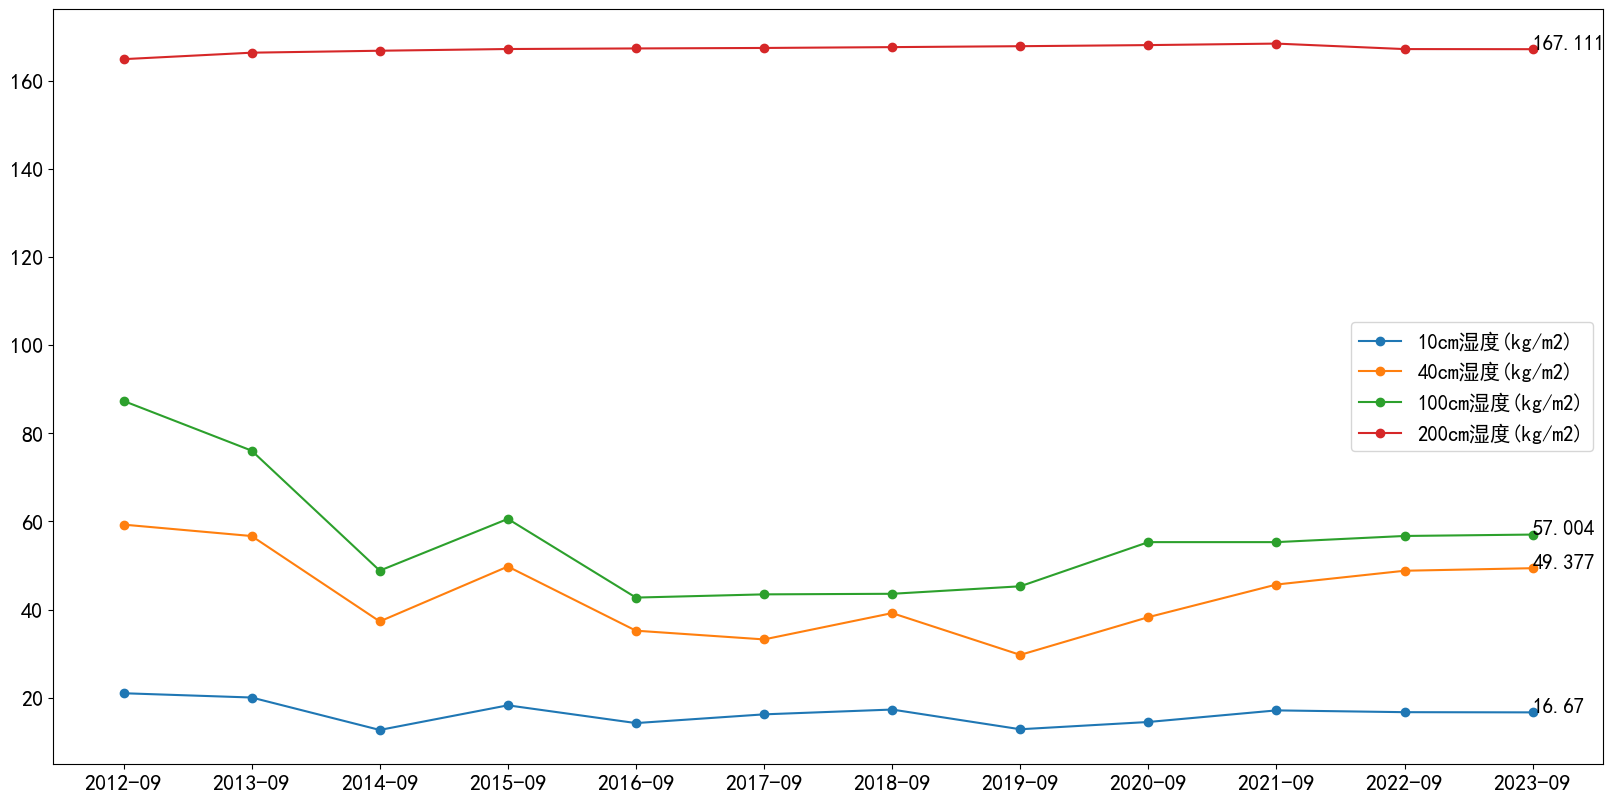

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10), dpi=100)

x_year = ["2012-09","2013-09","2014-09","2015-09",
          "2016-09","2017-09","2018-09","2019-09",
         "2020-09","2021-09","2022-09","2023-09"]
sd_data =  pd.read_excel("数据集/基本数据/附件3、土壤湿度2022—2012年.xls")
mon_9 = sd_data[sd_data["月份"]==9]
sd_10 = mon_9["10cm湿度(kg/m2)"].tolist()
sd_10.append(16.71481937)
sd_10.append(16.6698837)
sd_40 = mon_9["40cm湿度(kg/m2)"].tolist()
sd_40.append(48.7971453)
sd_40.append(49.37675148)
sd_100 = mon_9["100cm湿度(kg/m2)"].tolist()
sd_100.append(56.68719375)
sd_100.append(57.00425218)
sd_200 = mon_9["200cm湿度(kg/m2)"].tolist()
sd_200.append(167.136081)
sd_200.append(167.1110632)

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
plt.plot(x_year,sd_10,x_year,sd_40,x_year,sd_100,x_year,sd_200,marker = 'o')
plt.legend(["10cm湿度(kg/m2)","40cm湿度(kg/m2)","100cm湿度(kg/m2)","200cm湿度(kg/m2)"],fontsize =15)
plt.tick_params(labelsize=16)

plt.text("2023-09",sd_10[-1],round(sd_10[-1],3),fontsize =15)
plt.text("2023-09",sd_40[-1],round(sd_40[-1],3),fontsize =15)
plt.text("2023-09",sd_100[-1],round(sd_100[-1],3),fontsize =15)
plt.text("2023-09",sd_200[-1],round(sd_200[-1],3),fontsize =15)

plt.show()


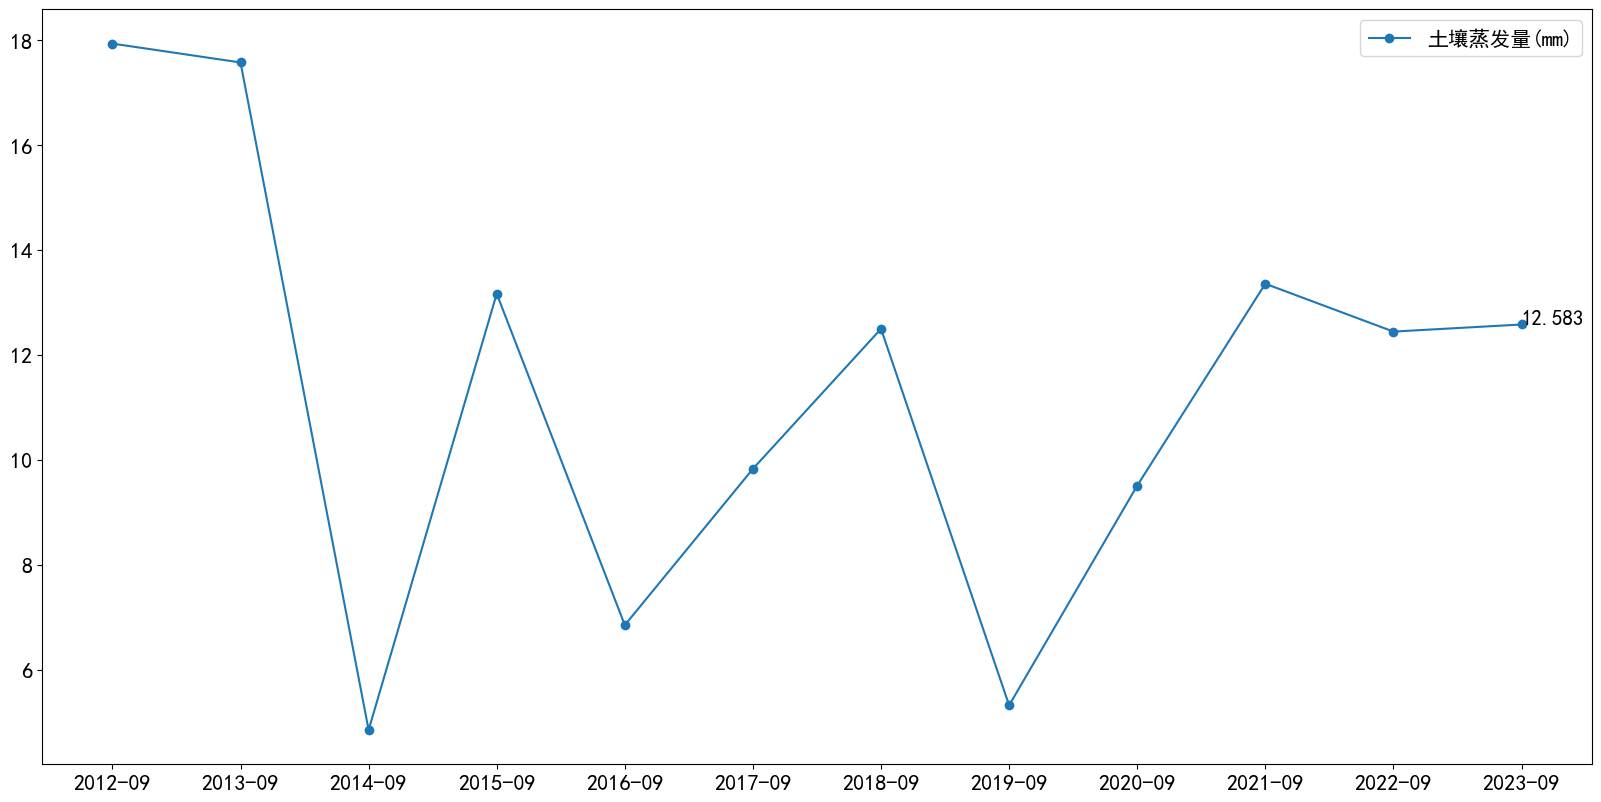

In [79]:
#蒸发量
zf_data = pd.read_excel("数据集/基本数据/附件4、土壤蒸发量2012—2022年.xls")

mon_9 = zf_data[zf_data["月份"]==9]
zf = mon_9["土壤蒸发量(mm)"].tolist()
zf.append(12.4474439115997)
zf.append(12.5827582641914)

plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
plt.plot(x_year,zf,marker = 'o')
plt.legend(["土壤蒸发量(mm)"],fontsize =15)
plt.tick_params(labelsize=16)
plt.text("2023-09",zf[-1],round(zf[-1],3),fontsize =15)

plt.show()

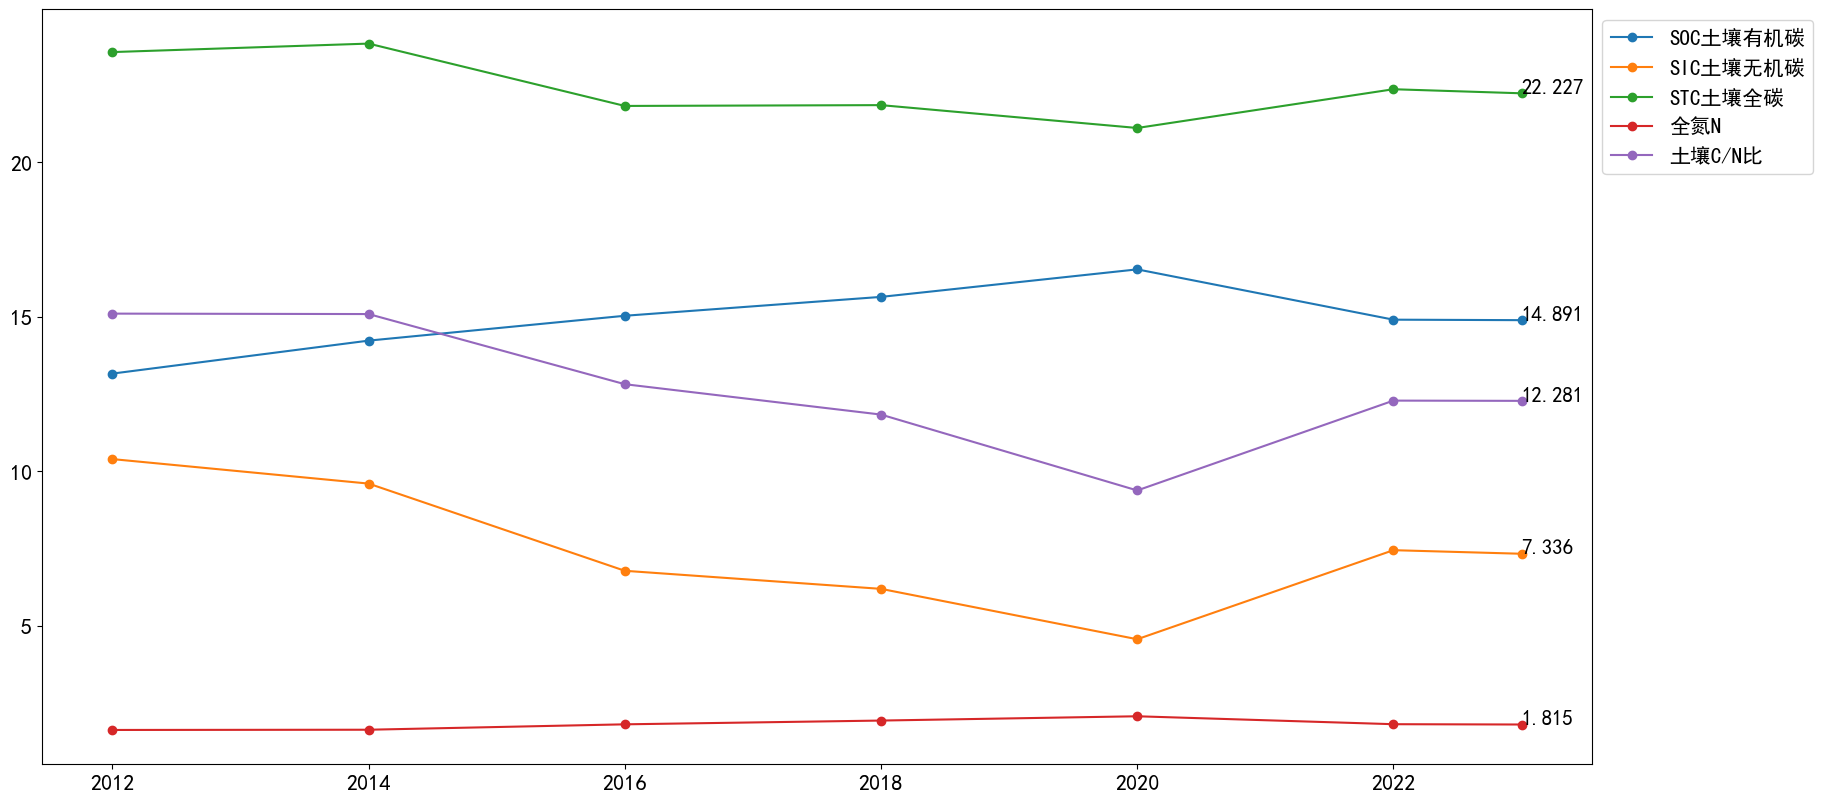

In [78]:
#土壤化学成分
hx_data = pd.read_excel("C:/Users/10371/Desktop/土壤化学成分.xlsx")

x = hx_data["year"]
y1 = hx_data["SOC土壤有机碳"].tolist()
y2 = hx_data["SIC土壤无机碳"].tolist()
y3 = hx_data["STC土壤全碳"].tolist()
y4 = hx_data["全氮N"].tolist()
y5 = hx_data["土壤C/N比"].tolist()
plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
plt.plot(x,y1,x,y2,x,y3,x,y4,x,y5,marker = 'o')
plt.legend(["SOC土壤有机碳","SIC土壤无机碳","STC土壤全碳","全氮N","土壤C/N比"],
           fontsize =15,bbox_to_anchor = (1,1))
plt.tick_params(labelsize=16)
plt.text(2023,y1[-1],round(y1[-1],3),fontsize =15)
plt.text(2023,y2[-1],round(y2[-1],3),fontsize =15)
plt.text(2023,y3[-1],round(y3[-1],3),fontsize =15)
plt.text(2023,y4[-1],round(y4[-1],3),fontsize =15)
plt.text(2023,y5[-1],round(y5[-1],3),fontsize =15)


plt.show()


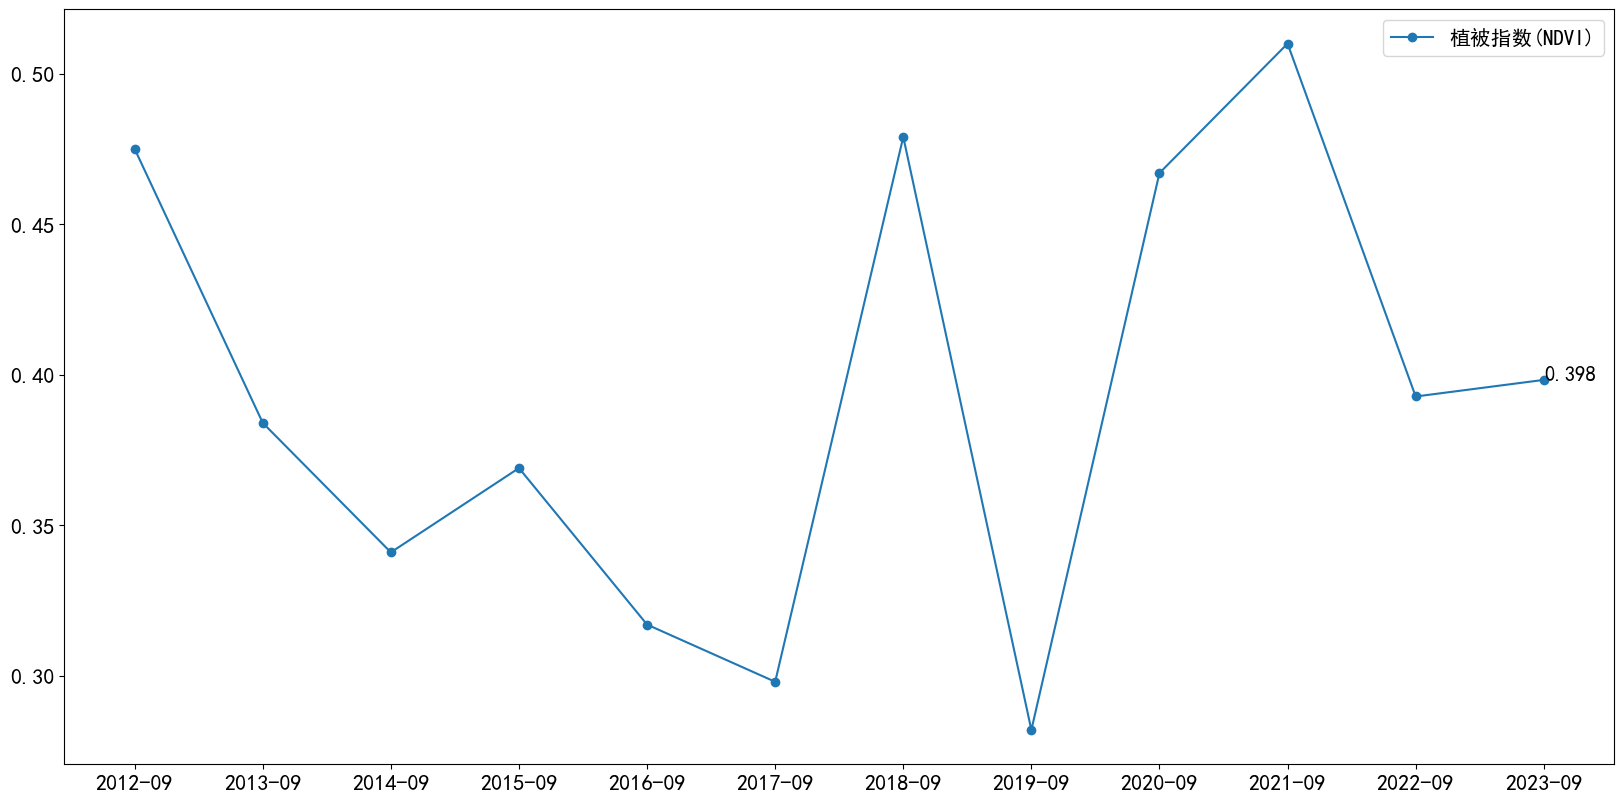

In [80]:
#NDVI
x_year = ["2012-09","2013-09","2014-09","2015-09",
          "2016-09","2017-09","2018-09","2019-09",
         "2020-09","2021-09","2022-09","2023-09"]
ndvi_data = pd.read_excel("C:/Users/10371/Desktop/附件6、植被指数-NDVI2012-2022年.xls")
y = ndvi_data[ndvi_data["月份"]==9]["植被指数(NDVI)"].tolist()
plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
plt.plot(x_year,y,marker = 'o')
plt.legend(["植被指数(NDVI)"],fontsize =15)
plt.tick_params(labelsize=16)

plt.text("2023-09",y[-1],round(y[-1],3),fontsize =15)

plt.show()